# 🌊 Deep Dive Into SVM
> **작성자 : 오수지 (2022020660)**

안녕하세요, 고려대학교 산업경영공학부 DSBA 연구실 석사과정 오수지입니다.  
이번 노트북 튜토리얼에선 대표적인 Kernel-based Learning 방법론인 **`Support Vector Machine`**에 대해 코드를 통해 알아볼 예정입니다. (🔎 SVM에 대한 기본적인 내용은 [유튜브 튜토리얼 영상](https://youtu.be/Kwmr9A6IBjI)을 참고해주세요.)

이번 튜토리얼에선 SVM을 이용해 재밌는 실험을 수행해볼 예정입니다! 유튜브 튜토리얼 동영상을 제작하며 **`Text Classification`**에서도 SVM을 활용할 수 있다는 사실을 알게 됐는데요. NLP 분야의 대표적인 학회인 EMNLP와 CV 분야의 대표적인 학회인 CVPR의 논문의 제목만을 가지고, 해당 논문이 어떤 학회의 논문인지 SVM이 얼마나 잘 구분해낼 수 있을까요?! 이 실험을 위해 실제 2022년 EMNLP accepted papers 파일과 CVPR accepted papers 파일을 가져와서 SVM을 학습시켜보았습니다👩🏻‍🏫

<img src="images/1_emnlp.png" width="450">
<img src="images/2_cvpr.png" width="450">

**📌 이번 튜토리얼의 목표 (feat. wandb를 이용한 예측 결과 시각화)**
>1. Text Classification에서 SVM의 성능 확인 : `EMNLP vs CVPR` 
>2. SVM의 각 하이퍼파라미터에 따른 성능 변화 분석 : `kernel, C, degree, gamma`
>3. Text Embedding 방식에 따른 성능 비교 : `TF-IDF, BERT embeddings`

**📌 Reference**
- https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
- https://www.kaggle.com/code/mehmetlaudatekman/text-classification-svm-explained
- https://www.kaggle.com/code/sainijagjit/text-classification-using-svm
- https://wandb.ai/lavanyashukla/visualize-sklearn/reports/Visualize-Scikit-Learn-Models-with-Weights-Biases--Vmlldzo0ODIzNg

## 🛠 환경 설정

In [5]:
!pip install xlrd==2.0.1  # for read xsl file
!pip install openpyxl  # for read xslx file
!pip install easydict

     |████████████████████████████████| 96 kB 7.0 MB/s  eta 0:00:01
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [1]:
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt
import easydict
import wandb
import nltk
from tqdm.auto import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings(action='ignore') 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, SVR
import sklearn.metrics as metrics

seed = 1201

---

## 1️⃣ 데이터 로드 및 학습 데이터프레임 구축
> EMNLP 엑셀 파일, CVPR 엑셀 파일을 각각 로드해서 **2개의 column으로(논문 제목, 라벨) 구성된 데이터프레임을 구축**하겠습니다!

📌 데이터 출처
- https://2022.emnlp.org/
- https://cvpr2022.thecvf.com/accepted-papers

In [2]:
# 데이터 로드
emnlp = pd.read_excel('./data/emnlp_2022_accepted_papers.xls')
cvpr = pd.read_excel('./data/cvpr_2022_accepted_papers.xlsx', engine='openpyxl')

In [3]:
emnlp.head(3)

,Submission ID,Title,Authors,Track,Submission Type,Acceptance Status,ARRLink,Abstract
0,1321,A Neural-Symbolic Approach to Natural Language...,"Zhixuan Liu, Zihao Wang, Yuan Lin and Hang Li",Ethic Concerns:Efficient Methods for NLP,Regular Long Paper,Accept-Conditional-Findings,NaN,"Deep neural networks, empowered by pre-trained..."
1,1810,Towards Intelligent Clinically-Informed Langua...,"Ankit Aich, Avery Quynh, Varsha Badal, Amy Pin...",Ethic Concerns:Resources and Evaluation,Regular Long Paper,Accept-Conditional-Findings,NaN,NLP offers a myriad of opportunities to suppor...
2,2293,Towards Identifying Social Bias in Dialog Syst...,"Jingyan ZHOU, Jiawen Deng, Fei Mi, Yitong Li, ...",Ethic Concerns:Ethics,Regular Long Paper,Accept-Conditional-Findings,NaN,Among all the safety concerns that hinder the ...


In [4]:
cvpr.head(3)

,Paper Title,Authors
0,Cascade Transformers for End-to-End Person Search,Rui Yu (The Pennsylvania State University); Da...
1,Compositional Temporal Grounding with Structur...,Juncheng Li (Zhejiang University)*; Junlin Xie...
2,Long-Tailed Recognition via Weight Balancing,Shaden N Alshammari (Massachusetts Institute o...


In [5]:
# 데이터 간에 조금의 데이터 불균형이 존재하는 걸 확인할 수 있습니다.
len(emnlp), len(cvpr)

(1381, 2065)

In [6]:
titles, labels = [], []

for emnlp_title in list(emnlp['Title']):
    titles.append(emnlp_title)
    labels.append('EMNLP')
    
for cvpr_title in list(cvpr['Paper Title']):
    titles.append(cvpr_title)
    labels.append('CVPR')

In [7]:
data = pd.DataFrame({'Title': titles, 'Label': labels})

In [8]:
data.head()

,Title,Label
0,A Neural-Symbolic Approach to Natural Language...,EMNLP
1,Towards Intelligent Clinically-Informed Langua...,EMNLP
2,Towards Identifying Social Bias in Dialog Syst...,EMNLP
3,Cards Against AI: Predicting Humor in a Fill-i...,EMNLP
4,ClinicalT5: A Generative Language Model for Cl...,EMNLP


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   3446 non-null   object
 1   Label   3446 non-null   object
dtypes: object(2)
memory usage: 54.0+ KB


### 🎨 EDA
> 각 학회별로 가장 자주 등장한 단어를 출력하는 간단한 EDA를 해보겠습니다!

- 결과적으로 EMNLP 논문에선 **language, learning, generation, knowledge, text** 등 언어와 관련된 키워드가, CVPR 논문에선 **image, 3D, detection, object, segmentation** 등 비전과 관련된 키워드가 많이 등장하는 사실을 확인할 수 있었습니다.
- 시각화를 진행한 이후에 불용어가 많이 등장하는 것이 확인되어 불용어를 제거하는 전처리를 수행했지만 결과적으로 성능이 떨어져서 전처리 과정은 생략하게 되었습니다.
    - 불용어 제거시 for, and와 같이 논문 제목 내 불필요한 불용어뿐만 아니라 with, against와 같이 논문 제목에서 중요한 역할을 하는 불용어도 함께 제거되기 때문에 성능이 하락했다고 생각합니다.

In [10]:
emnlp_fd = nltk.FreqDist(word for text in data[data["Label"] == "EMNLP"]["Title"] for word in text.lower().split())
cvpr_fd = nltk.FreqDist(word  for text in data[data["Label"] == "CVPR"]["Title"] for word in text.lower().split())

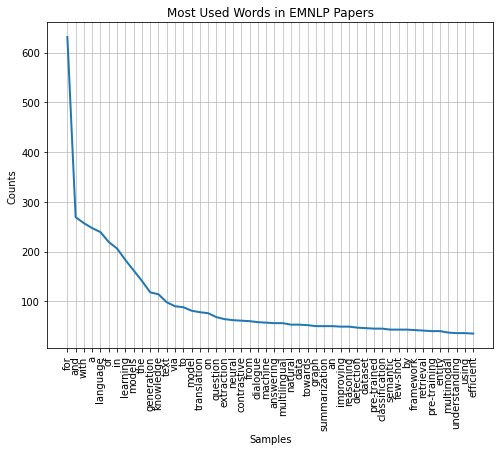

In [11]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in EMNLP Papers")
emnlp_fd.plot(50)
plt.show()

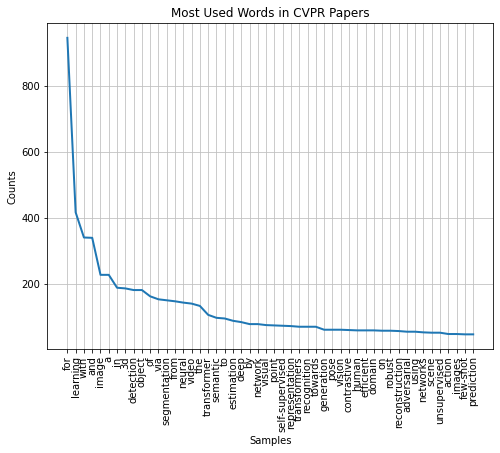

In [12]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in CVPR Papers")
cvpr_fd.plot(50)
plt.show()

---

## 2️⃣ 모델 학습 데이터 준비

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data['Title'], data['Label'], 
                                                    shuffle=True, test_size = 0.2, random_state = seed)

- Text로 된 라벨을 숫자로 인코딩합니다.

In [14]:
# Before
print(list(y_train[:10]))

['CVPR', 'EMNLP', 'EMNLP', 'EMNLP', 'EMNLP', 'EMNLP', 'CVPR', 'CVPR', 'CVPR', 'CVPR']


In [15]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [16]:
# AFTER
print(list(y_train[:10]))

[0, 1, 1, 1, 1, 1, 0, 0, 0, 0]


- Text로 된 Title을 SVM의 input으로 사용할 수 있도록 Numerical Feature Vector로 변경합니다.
- Text를 Vector로 바꾸는 방법은 여러가지가 있지만 가장 대표적인 방법인 **TF-IDF**, 개인적으로 가장 결과가 궁금한 방법인 **BERT의 hidden representation**을 활용하는 방식 2가지를 실험해볼 예정입니다.
    - BERT는 가장 기본적인 `bert-base-uncased` 모델을 활용하겠습니다.

- **TF-IDF**

In [17]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(data['Title'])
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [18]:
X_train_tfidf.shape, X_test_tfidf.shape

((2756, 4981), (690, 4981))

- **BERT**
    - BERT의 hidden representation을 SVM의 input으로 활용하는 방법은 다양합니다.
        - BERT의 12개의 layer에 대해 각 token representation을 평균내서 구한 token별 벡터를 활용 (Ray et al., 2020)
        - BERT의 마지막 4개의 layer에 대해 각 layer에서 전체 token representation을 평균내서 구한 4개의 벡터를 mairesse feature와 concat해서 활용 (Kazameini et al., 2020)
        
        <img src="images/winlp.png" width="700">
        
    - 해당 튜토리얼에선 **(1) [CLS] token의 임베딩을 활용하는 방법 (2) 전체 Token의 임베딩을 평균내는 방법** 2가지 방식에 대한 결과를 확인해볼 예정입니다.
    - Reference
        - [Factuality Classification Using BERT Embeddings and Support Vector Machines (IberLEF@SEPLN 2020)](http://ceur-ws.org/Vol-2664/fact_paper2.pdf)
        - [Depression Prediction using BERT and SVM (IRJET 2022)](https://www.irjet.net/archives/V9/i3/IRJET-V9I3366.pdf)
        - [Personality Trait Detection Using Bagged SVM over BERT Word Embedding Ensembles (WiNLP 2020)](https://arxiv.org/pdf/2010.01309.pdf)

In [19]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
X_train_cls, X_train_avg = [], []

for title in tqdm(list(X_train)):
    inputs = tokenizer(title, 
                       max_length=32, 
                       padding='max_length', 
                       return_tensors="pt")
    outputs = model(**inputs)
    cls_vector = outputs.pooler_output.squeeze().detach().numpy().tolist()
    avg_vector = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy().tolist()
    X_train_cls.append(cls_vector)
    X_train_avg.append(avg_vector)

  0%|          | 0/2756 [00:00<?, ?it/s]

In [21]:
X_test_cls, X_test_avg = [], []

for title in tqdm(list(X_test)):
    inputs = tokenizer(title, 
                       max_length=32, 
                       padding='max_length', 
                       return_tensors="pt")
    outputs = model(**inputs)
    cls_vector = outputs.pooler_output.squeeze().detach().numpy().tolist()
    avg_vector = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy().tolist()
    X_test_cls.append(cls_vector)
    X_test_avg.append(avg_vector)

  0%|          | 0/690 [00:00<?, ?it/s]

In [22]:
X_train_cls = np.asarray(X_train_cls)
X_train_avg = np.asarray(X_train_avg)
X_test_cls = np.asarray(X_test_cls)
X_test_avg = np.asarray(X_test_avg)

In [23]:
X_train_cls.shape, X_test_cls.shape

((2756, 768), (690, 768))

In [24]:
X_train_avg.shape, X_test_avg.shape

((2756, 768), (690, 768))

---

## 3️⃣ Hyperparameter 변화에 따른 성능 분석

- **`C`** = [0.01, 0.1, 1, 10]  
    - C는 **SVM에게 얼마나 error를 허용할 것인지를 결정**하는 하이퍼파라미터로, C가 클수록 decision boundary가 error를 갖는 데이터 포인트들에 대해 강하게 페널티를 주므로 margin이 작아지고, C가 작을수록 margin이 커집니다. C가 너무 크다면 SVM이 이상치에도 예민하게 반응해서 학습 데이터에 오버피팅될 수 있는 위험이 있습니다.


<img src="images/c_2.png" width="450"> <img src="images/c_3.png" width="450">


- **`degree`** = [1, 3, 5]
    - degree는 **다항식의 차수를 결정**하는 하이퍼파라미터로, 차수가 높을수록 복잡한 decision boundary가 생성되며, 낮을수록 단순한 decision boundary가 생성됩니다.


<img src="images/degree.png" width="450">  


- **`gamma`** = [0.01, 0.1, 1, 10]
    - gamma는 **하나의 데이터 샘플이 영향력을 행사하는 거리를 결정**하는 하이퍼파라미터로, gamma에 따라 decision boundary가 유연하게 그려지는 정도, 즉 decision boundary의 곡률이 정해집니다. gamma가 클수록 각 데이터 포인트들이 영향력을 행사하는 거리가 짧아지므로 decision boundary가 구불구불해지고, gamma가 작을수록 각 데이터 포인트들이 영향력을 행사하는 거리가 커지므로 decision boundary가 직선과 가깝게 그려집니다. 그림에서 0.008, 0.01과 같이 gamma를 매우 작게 준 경우엔 모델이 실제 데이터의 특성을 잡아내지 못하고 선형 모델의 결과와 비슷한 결과를 내고 있는 반면 3.0, 7.0, 11.0과 같이 gamma가 점점 커질수록 학습 데이터에 오버피팅되어가는 것을 확인할 수 있습니다.
    
    
<img src="images/gamma.png" width="450">
    
    
📌 이미지 출처
- https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/
- https://eunsukimme.github.io/ml/2019/11/04/SVM/
- https://towardsdatascience.com/support-vector-machine-803884d967e3
- https://www.researchgate.net/publication/23442384_Support_Vector_Machines_and_Kernels_for_Computational_Biology

📌 Reference
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://eunsukimme.github.io/ml/2019/11/04/SVM/
- https://hleecaster.com/ml-svm-concept/
- https://hleecaster.com/ml-svm-concept/

- 각 커널 함수별 실험을 진행하지 않는 option들도 train_SVM 함수에서 공통적으로 인자를 받기 때문에 공식 홈페이지에서 설정한 default 값을 입력을 주었습니다.


In [27]:
C_list = [0.01, 0.1, 1, 10]
degree_list = [1, 3, 5]
gamma_list = [0.01, 0.1, 1, 10]

In [28]:
# Linear Kernel : C 값에 따른 성능 측정
linear_args = easydict.EasyDict({
    "kernel" : "linear",
    "C" : 1.0,
    "degree" : 3,
    "gamma" : "scale"
})

# Polynomial Kernel : C 값, Degree 값에 따른 성능 측정
poly_args = easydict.EasyDict({
    "kernel" : "poly",
    "C" : 1.0,
    "degree" : 3,
    "gamma" : "scale"
})


# RBF Kernel : C 값, Gamma 값에 따른 성능 측정
rbf_args = easydict.EasyDict({
    "kernel" : "rbf",
    "C" : 1.0,
    "degree" : 3,
    "gamma" : "scale"
})

- 조금 더 편리한 실험 수행을 위해 모델 학습과 결과 확인을 위한 함수를 정의하고 시작하겠습니다!

In [29]:
def train_SVM(args, X_train, X_test, y_train, y_test):
    SVM = SVC(kernel=args.kernel, C=args.C, degree=args.degree, gamma=args.gamma, 
              max_iter=10000, random_state=seed, probability=True)
    SVM.fit(X_train, y_train)
    predictions = SVM.predict(X_test)
    probas = SVM.predict_proba(X_test)
    
    # Visualize using wandb
    wandb.init()
    run_name = f"kernel_{args.kernel}_C_{args.C}_degree_{args.degree}_gamma_{args.gamma}"
    wandb.run.name = run_name
    wandb.sklearn.plot_roc(y_test, probas, labels=['EMNLP', 'CVPR'])
    wandb.sklearn.plot_precision_recall(y_test, probas, labels=['EMNLP', 'CVPR'])
    wandb.sklearn.plot_confusion_matrix(y_test, predictions, labels=['EMNLP', 'CVPR'])
    wandb.finish()
    
    return run_name, predictions

In [30]:
def print_result(run_name, predictions):
    for idx, name in enumerate(run_name):
        print("-"*20)
        print(f"Name: {name}")
        print(f"Accuracy: {metrics.accuracy_score(y_test, predictions[idx])*100:.2f}")
        print(f"Precision: {metrics.precision_score(y_test, predictions[idx])*100:.2f}")
        print(f"Recall: {metrics.recall_score(y_test, predictions[idx])*100:.2f}")
        print(f"F1-Score: {metrics.f1_score(y_test, predictions[idx])*100:.2f}")

### ① Linear Kernel
> **`C=1`**일 때, Accuracy 기준 **91.30**으로 가장 높은 성능을 냈습니다. 0.01, 0.1과 같이 C가 너무 작은 경우엔 데이터를 잘 구분해내지 못하는 decision boundry가 형성되어 61.01, 80.43과 같이 확연히 낮은 성능을 보인 점을 확인할 수 있었습니다. 반대로 C가 10으로 큰 값을 가질 때도 C=1일 때와 비교하여 약간의 성능 하락을 보였는데 이는 큰 penalty로 인해 오버피팅이 발생했기 때문이라고 생각합니다.

||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|C=0.01|61.01|0.00|0.00|0.00|
|C=0.1|80.43|96.53|51.67|67.31|
|C=1|**91.30**|90.04|87.36|88.68|
|C=10|89.42|86.84|85.87|86.36|

In [31]:
lk_run_name, lk_preds = [], []

for C in C_list:
    linear_args.C = C
    run_name, preds = train_SVM(linear_args, X_train_tfidf, X_test_tfidf, y_train, y_test)
    lk_run_name.append(run_name)
    lk_preds.append(preds)

wandb: Currently logged in as: ohsuz. Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


In [32]:
print_result(lk_run_name, lk_preds)

--------------------
Name: kernel_linear_C_0.01_degree_3_gamma_scale
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
--------------------
Name: kernel_linear_C_0.1_degree_3_gamma_scale
Accuracy: 80.43
Precision: 96.53
Recall: 51.67
F1-Score: 67.31
--------------------
Name: kernel_linear_C_1_degree_3_gamma_scale
Accuracy: 91.30
Precision: 90.04
Recall: 87.36
F1-Score: 88.68
--------------------
Name: kernel_linear_C_10_degree_3_gamma_scale
Accuracy: 89.42
Precision: 86.84
Recall: 85.87
F1-Score: 86.36


### ② Polynomial Kernel

> **`C=10`**일 때, Accuracy 기준 **75.51**로 가장 높은 성능을 냈습니다. degree를 변경한 실험 결과에서 degree가 커질수록 성능이 낮아지는 것을 확인할 수 있었는데 실험에서 사용한 default degree 값이 3이므로 전반적으로 낮은 성능을 보이는 점을 확인할 수 있으며, degree=3으로 인해 복잡한 decision boundary를 가지는 상황에선 penalty를 높게 줘서 아예 decision boundary가 더 데이터에 피팅되게 하는 것이 좋은 성능을 내는 방향이라고 해석했습니다.

||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|C=0.01|61.01|0.00|0.00|0.00|
|C=0.1|61.01|0.00|0.00|0.00|
|C=1|72.46|97.59|30.11|46.02|
|C=10|**75.51**|98.08|37.92|54.69|

> **`degree=1`**일 때, Accuracy 기준 **91.30**으로 가장 높은 성능을 냈습니다. Linear Kernel을 사용했을 때 91.30의 좋은 성능을 보였던 점을 생각해보면 해당 데이터는 데이터간 경계가 비교적 뚜렷한 데이터이므로, 복잡한 decision boundary보단 단순한 decision boundary가 생성되었을 때 더 좋은 성능을 낼 수 있었던 것으로 생각됩니다.

||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|degree=1|**91.30**|90.04|87.36|88.68|
|degree=3|72.46|97.59|30.11|46.02|
|degree=5|61.01|0.00|0.00|0.00|

In [33]:
pk_run_name_c, pk_preds_c = [], []

for C in C_list:
    poly_args.C = C
    run_name, preds = train_SVM(poly_args, X_train_tfidf, X_test_tfidf, y_train, y_test)
    pk_run_name_c.append(run_name)
    pk_preds_c.append(preds)

In [34]:
print_result(pk_run_name_c, pk_preds_c)

--------------------
Name: kernel_poly_C_0.01_degree_3_gamma_scale
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
--------------------
Name: kernel_poly_C_0.1_degree_3_gamma_scale
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
--------------------
Name: kernel_poly_C_1_degree_3_gamma_scale
Accuracy: 72.46
Precision: 97.59
Recall: 30.11
F1-Score: 46.02
--------------------
Name: kernel_poly_C_10_degree_3_gamma_scale
Accuracy: 75.51
Precision: 98.08
Recall: 37.92
F1-Score: 54.69


In [35]:
pk_run_name_degree, pk_preds_degree = [], []

poly_args.C = 1  # reset C to default value before changing degree
for degree in degree_list:
    poly_args.degree = degree
    run_name, preds = train_SVM(poly_args, X_train_tfidf, X_test_tfidf, y_train, y_test)
    pk_run_name_degree.append(run_name)
    pk_preds_degree.append(preds)

In [36]:
print_result(pk_run_name_degree, pk_preds_degree)

--------------------
Name: kernel_poly_C_1_degree_1_gamma_scale
Accuracy: 91.30
Precision: 90.04
Recall: 87.36
F1-Score: 88.68
--------------------
Name: kernel_poly_C_1_degree_3_gamma_scale
Accuracy: 72.46
Precision: 97.59
Recall: 30.11
F1-Score: 46.02
--------------------
Name: kernel_poly_C_1_degree_5_gamma_scale
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


### ③ RBF Kernel
> **`C=10`**일 때, Accuracy 기준 **91.45**로 가장 높은 성능을 냈습니다. Polynomial Kernel에서의 해석과 마찬가지로 decision boundary가 데이터에 적절히 피팅되었기 때문이라고 생각합니다.

||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|C=0.01|61.01|0.00|0.00|0.00|
|C=0.1|61.16|100.00|0.37|0.74|
|C=1|90.87|92.56|83.27|87.67|
|C=10|**91.45**|91.34|86.25|88.72|

> **`gamma=1`**일 때, Accuracy 기준 **90.87**로 가장 높은 성능을 냈습니다. gamma가 작을 땐 단순한 decision boundary가 형성되므로 예측을 제대로 하지 못해서 낮은 성능을 보이고 있고, 반대로 너무 큰 경우에는 학습 데이터에 심하게 오버피팅 되어 낮은 성능을 보이는 것으로 생각됩니다.

||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|gamma=0.01|61.01|0.00|0.00|0.00|
|gamma=0.1|86.67|93.60|70.63|80.51|
|gamma=1|**90.87**|92.56|83.27|87.67|
|gamma=10|61.01|0.00|0.00|0.00|

In [37]:
rk_run_name_c, rk_preds_c = [], []

for C in C_list:
    rbf_args.C = C
    run_name, preds = train_SVM(rbf_args, X_train_tfidf, X_test_tfidf, y_train, y_test)
    rk_run_name_c.append(run_name)
    rk_preds_c.append(preds)

In [38]:
print_result(rk_run_name_c, rk_preds_c)

--------------------
Name: kernel_rbf_C_0.01_degree_3_gamma_scale
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
--------------------
Name: kernel_rbf_C_0.1_degree_3_gamma_scale
Accuracy: 61.16
Precision: 100.00
Recall: 0.37
F1-Score: 0.74
--------------------
Name: kernel_rbf_C_1_degree_3_gamma_scale
Accuracy: 90.87
Precision: 92.56
Recall: 83.27
F1-Score: 87.67
--------------------
Name: kernel_rbf_C_10_degree_3_gamma_scale
Accuracy: 91.45
Precision: 91.34
Recall: 86.25
F1-Score: 88.72


In [39]:
rk_run_name_gamma, rk_preds_gamma = [], []

rbf_args.C = 1  # reset C to default value before changing gamma
for gamma in gamma_list:
    rbf_args.gamma = gamma
    run_name, preds = train_SVM(rbf_args, X_train_tfidf, X_test_tfidf, y_train, y_test)
    rk_run_name_gamma.append(run_name)
    rk_preds_gamma.append(preds)

In [40]:
print_result(rk_run_name_gamma, rk_preds_gamma)

--------------------
Name: kernel_rbf_C_1_degree_3_gamma_0.01
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
--------------------
Name: kernel_rbf_C_1_degree_3_gamma_0.1
Accuracy: 86.67
Precision: 93.60
Recall: 70.63
F1-Score: 80.51
--------------------
Name: kernel_rbf_C_1_degree_3_gamma_1
Accuracy: 90.87
Precision: 92.56
Recall: 83.27
F1-Score: 87.67
--------------------
Name: kernel_rbf_C_1_degree_3_gamma_10
Accuracy: 61.01
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


## 4️⃣ Text Embedding 방식에 따른 성능 변화 분석
> TF-IDF embedding을 이용했을 때 Accuracy 기준 **91.45**로 가장 좋은 성능을 냈던 **`RBF kernel(C=10)`** 설정에 대해 BERT Embedding의 성능을 확인해본 결과, BERT의 Avg Embedding이 TF-IDF보다 Accuracy 기준 약 0.3 낮은 성능을 보였습니다. BERT embedding을 활용했을 때보다 TF-IDF embedding을 활용했을 때 더 높은 성능을 보인 결과에 대한 개인적인 해석은 다음과 같습니다.  
>1. 실험에서 사용한 bert-base-uncased 모델이 다른 PLM들에 비해 모델 크기도 작고, 학습한 데이터도 작은 모델입니다. 만약 더 큰 corpus로 학습한 RoBERTa와 같은 모델을 활용했다면 더 높은 성능을 낼 수 있었을 거라고 생각합니다.
>2. 여러 layer의 token representation을 활용한 다른 논문과 달리 전 마지막 layer의 token representation만 사용했습니다. 다른 논문들처럼 여러 layer의 output들을 평균내는 추가적인 방식을 취했다면 각 token별 더 다양한 representation을 반영할 수 있으므로 더 높은 성능을 낼 수 있었을 거라고 생각합니다.
>3. TF-IDF를 위해 구축된 DTM, 즉 Vocab의 개수가 4,981개로 크지 않습니다. 또한 각 학회별 자주 등장한 단어를 시각화했을 때 자주 등장한 단어간 차이가 뚜렷했으므로 TF-IDF embedding이 좋은 성능을 낼 수 있었다고 생각합니다.


||Accuracy|Precision|Recall|F1-Score|
|:---|:---:|:---:|:---:|:---:|
|TF-IDF|**91.45**|91.34|86.25|88.72|
|BERT(cls)|85.07|83.74|76.58|80.00|
|BERT(avg)|88.99|87.55|83.64|85.55|

In [50]:
best_args = easydict.EasyDict({
    "kernel" : "rbf",
    "C" : 10,
    "degree" : 3,
    "gamma" : "scale"
})

### ① BERT embeddings : [CLS]

In [51]:
cls_run_name, cls_preds = train_SVM(best_args, X_train_cls, X_test_cls, y_train, y_test)

In [53]:
print_result([cls_run_name], [cls_preds])

--------------------
Name: kernel_rbf_C_10_degree_3_gamma_scale
Accuracy: 85.07
Precision: 83.74
Recall: 76.58
F1-Score: 80.00


### ② BERT embeddings : Avg

In [54]:
avg_run_name, avg_preds = train_SVM(best_args, X_train_avg, X_test_avg, y_train, y_test)

In [56]:
print_result([avg_run_name], [avg_preds])

--------------------
Name: kernel_rbf_C_10_degree_3_gamma_scale
Accuracy: 88.99
Precision: 87.55
Recall: 83.64
F1-Score: 85.55


> 최신 데이터를 가지고 관심 분야의 SVM 성능을 확인할 수 있었던 재밌는 시간이었습니다. 그럼 다음 튜토리얼에 **`Anomaly Detection`**으로 다시 찾아뵙겠습니다.

<img src="images/9_turtle.png" width="300">

> 🔐 https://wandb.ai/ohsuz/2022-2-Business-Analytics-Tutorials 를 방문하면 노트북에서 진행한 모든 실험에 대한 ROC Curve, Confusion Matrix를 시각적으로 확인할 수 있습니다.


<img src="images/wandb_kernel.png" width="500">